# Install missing required packages


In [ ]:
# Install pybullet
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 MB 9.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.8/432.8 kB 14.4 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

# Cartpole Setup

## base enviroment

In [ ]:
import abc
import pybullet as p
import pybullet_data as pd
import gym

class BaseEnv(object):

    def __init__(self, dt=0.05):
        self.sim = p.connect(p.DIRECT)
        self.dt = dt
        self.state = None
        self.render_h = None
        self.render_w = None
        self.view_matrix = None
        self.proj_matrix = None
        self.action_space = self._get_action_space()
        self.state_space = self._get_state_space()
        self.reset()

    @abc.abstractmethod
    def step(self, action):
        pass

    @abc.abstractmethod
    def reset(self, state=None):
        pass

    @abc.abstractmethod
    def get_state(self):
        pass

    @abc.abstractmethod
    def set_state(self, state):
        pass

    @abc.abstractmethod
    def _get_action_space(self):
        pass

    @abc.abstractmethod
    def _get_state_space(self):
        pass

    @abc.abstractmethod
    def _setup_camera(self):
        pass

    def dynamics(self, state, control):
        # first we save the state of the simulation so we can return to it
        saved_sim_state = self.get_state()

        # Use the simulator to query the dynamics
        self.set_state(state)
        next_state = self.step(control)

        # Reset the simulator to saved state
        self.set_state(saved_sim_state)
        return next_state

    def batched_dynamics(self, state, control):
        state_shape = state.shape
        if len(state_shape) > 1:
            state = state.reshape((-1, state.shape[-1]))
            action = control.reshape((-1, control.shape[-1]))
            next_state = []
            for i, state_i in enumerate(state):
                action_i = action[i]
                next_state_i = self.dynamics(state_i, action_i)
                next_state.append(next_state_i)
            next_state = np.stack(next_state, axis=0).reshape(state_shape)
        else:
            next_state = self.dynamics(state, control)
        return next_state

    def rollout(self, initial_state, control_sequence):
        self.reset(state=initial_state)
        states = []
        for control in control_sequence:
            state = self.step(control)
            states.append(state)
        return np.stack(states, axis=0)

    def render(self):
        (_, _, px, _, _) = p.getCameraImage(
            width=self.render_w,
            height=self.render_h,
            renderer=p.ER_BULLET_HARDWARE_OPENGL,
            viewMatrix=self.view_matrix,
            projectionMatrix=self.proj_matrix)

        # rgb_array = np.array(px, dtype=np.uint8)
        rgb_array = np.reshape(np.array(px), (self.render_h, self.render_w, -1))
        rgb_array = rgb_array[:, :, :3]
        return rgb_array

## Our enviroment

In [ ]:
class CartpoleEnv(BaseEnv):

    def __init__(self, *args, **kwargs):
        self.cartpole = None
        super().__init__(*args, **kwargs)

    def step(self, control):
        """
            Steps the simulation one timestep, applying the given force
        Args:
            control: np.array of shape (1,) representing the force to apply

        Returns:
            next_state: np.array of shape (4,) representing next cartpole state

        """
        p.setJointMotorControl2(self.cartpole, 0, p.TORQUE_CONTROL, force=control[0])
        p.stepSimulation()
        return self.get_state()

    def reset(self, state=None):
        """
            Resets the environment
        Args:
            state: np.array of shape (4,) representing cartpole state to reset to.
                   If None then state is randomly sampled
        """
        if state is not None:
            self.state = state
        else:
            self.state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        p.resetSimulation()
        p.setAdditionalSearchPath(pd.getDataPath())
        self.cartpole = p.loadURDF('cartpole.urdf')
        p.setGravity(0, 0, -9.81)
        p.setTimeStep(self.dt)
        p.setRealTimeSimulation(0)
        p.changeDynamics(self.cartpole, 0, linearDamping=0, angularDamping=0,
                         lateralFriction=0, spinningFriction=0, rollingFriction=0)
        p.changeDynamics(self.cartpole, 1, linearDamping=0, angularDamping=0,
                         lateralFriction=0, spinningFriction=0, rollingFriction=0)
        p.changeDynamics(self.cartpole, -1, linearDamping=0, angularDamping=0,
                         lateralFriction=0, spinningFriction=0, rollingFriction=0)
        p.setJointMotorControl2(self.cartpole, 1, p.VELOCITY_CONTROL, force=0)
        p.setJointMotorControl2(self.cartpole, 0, p.VELOCITY_CONTROL, force=0)
        self.set_state(self.state)
        self._setup_camera()

    def get_state(self):
        """
            Gets the cartpole internal state

        Returns:
            state: np.array of shape (4,) representing cartpole state [x, theta, x_dot, theta_dot]

        """

        x, x_dot = p.getJointState(self.cartpole, 0)[0:2]
        theta, theta_dot = p.getJointState(self.cartpole, 1)[0:2]
        return np.array([x, theta, x_dot, theta_dot])

    def set_state(self, state):
        x, theta, x_dot, theta_dot = state
        p.resetJointState(self.cartpole, 0, targetValue=x, targetVelocity=x_dot)
        p.resetJointState(self.cartpole, 1, targetValue=theta, targetVelocity=theta_dot)

    def _get_action_space(self):
        action_space = gym.spaces.Box(low=-30, high=30)  # linear force # TODO: Verify that they are correct
        return action_space

    def _get_state_space(self):
        x_lims = [-5, 5]  # TODO: Verify that they are the correct limits
        theta_lims = [-np.pi, np.pi]
        x_dot_lims = [-10, 10]
        theta_dot_lims = [-5 * np.pi, 5 * np.pi]
        state_space = gym.spaces.Box(low=np.array([x_lims[0], theta_lims[0], x_dot_lims[0], theta_dot_lims[0]]),
                                     high=np.array([x_lims[1], theta_lims[1], x_dot_lims[1], theta_dot_lims[
                                         1]]))  # linear force # TODO: Verifty that they are correct
        return state_space

    def _setup_camera(self):
        self.render_h = 240
        self.render_w = 320
        base_pos = [0, 0, 0]
        cam_dist = 2
        cam_pitch = 0.3
        cam_yaw = 0
        self.view_matrix = p.computeViewMatrixFromYawPitchRoll(
            cameraTargetPosition=base_pos,
            distance=cam_dist,
            yaw=cam_yaw,
            pitch=cam_pitch,
            roll=0,
            upAxisIndex=2)
        self.proj_matrix = p.computeProjectionMatrixFOV(fov=60,
                                                        aspect=self.render_w / self.render_h,
                                                        nearVal=0.1,
                                                        farVal=100.0)

    def linearize_numerical(self, state, control, eps=1e-3):
        """
            Linearizes cartpole dynamics around linearization point (state, control). Uses numerical differentiation
        Args:
            state: np.array of shape (4,) representing cartpole state
            control: np.array of shape (1,) representing the force to apply
            eps: Small change for computing numerical derivatives
        Returns:
            A: np.array of shape (4, 4) representing Jacobian df/dx for dynamics f
            B: np.array of shape (4, 1) representing Jacobian df/du for dynamics f
        """
        A, B = None, None
        # --- Your code here
        idx1 = np.array([1, 0, 0, 0])
        idx2 = np.array([0, 1, 0, 0])
        idx3 = np.array([0, 0, 1, 0])
        idx4 = np.array([0, 0, 0, 1])
        A1 = (self.dynamics(state+eps*idx1, control)-self.dynamics(state-eps*idx1, control)) /2 /eps
        A2 = (self.dynamics(state+eps*idx2, control)-self.dynamics(state-eps*idx2, control)) /2 /eps
        A3 = (self.dynamics(state+eps*idx3, control)-self.dynamics(state-eps*idx3, control)) /2 /eps
        A4 = (self.dynamics(state+eps*idx4, control)-self.dynamics(state-eps*idx4, control)) /2 /eps
        B = (self.dynamics(state, control+eps)-self.dynamics(state, control-eps)) /2 /eps
        A = np.vstack((A1, A2, A3, A4))
        A = A.T
        B = B[:, None]
        # ---
        return A, B

  0%|          | 0/100 [00:00<?, ?it/s]

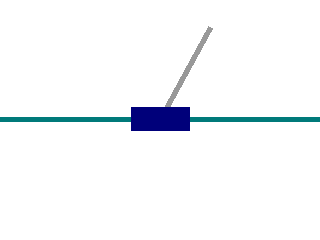

In [ ]:
env = CartpoleEnv()
env.reset(state = np.array([0.0, 0.5, 0.0, 0.0]))

frames=[] #frames to create animated png
frames.append(env.render())
for i in tqdm(range(100)):
    action = env.action_space.sample()
    s = env.step(action)
    img = env.render()
    frames.append(img)

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")

# dynamics analytic


In [ ]:
def dynamics_analytic(state, action):
    """
        Computes x_t+1 = f(x_t, u_t) using analytic model of dynamics in Pytorch
        Should support batching
    Args:
        state: torch.tensor of shape (B, 4) representing the cartpole state
        control: torch.tensor of shape (B, 1) representing the force to apply

    Returns:
        next_state: torch.tensor of shape (B, 4) representing the next cartpole state

    """
    next_state = None
    dt = 0.05
    g = 9.81
    mc = 1
    mp = 0.1
    l = 0.5

    # --- Your code here
    mt = mp + mc
    # state
    x, theta, dx, dtheta = torch.chunk(state, 4, 1)
    # print(x, theta, dx, dtheta)
    st = torch.sin(theta)
    ct = torch.cos(theta)

    # Compute accelerations
    tacc = (g * st - ct * (action + mp * l * dtheta ** 2 * st) / mt) / (l * ((4.0 / 3.0) - ((mp * ct ** 2) / mt)))
    xacc = (action + mp * l * (dtheta ** 2 * st - tacc * ct)) / mt

    #### be careful the order

    # Update velocities.
    dx = dx + xacc * dt
    dtheta = dtheta + tacc * dt

    # Update position/angle.
    x = x + dt * dx
    theta = theta + dt * dtheta



    next_state = torch.cat([x, theta, dx, dtheta], dim = 1)
    # ---

    return next_state


def linearize_pytorch(state, control):
    """
        Linearizes cartpole dynamics around linearization point (state, control). Uses autograd of analytic dynamics
    Args:
        state: torch.tensor of shape (4,) representing cartpole state
        control: torch.tensor of shape (1,) representing the force to apply

    Returns:
        A: torch.tensor of shape (4, 4) representing Jacobian df/dx for dynamics f
        B: torch.tensor of shape (4, 1) representing Jacobian df/du for dynamics f

    """
    A, B = None, None
    # --- Your code here
    state = torch.reshape(state, (1, 4))
    control = torch.reshape(control, (1, 1))
    A, B = jacobian(dynamics_analytic,(state,control))
    A, B = A[0, :, 0, :], B[0, :, 0, :]
    # ---
    return A, B

# Optimization
implement one of the following
algorithms:

ROB 498 Final Project 2

a. iLQR (https://homes.cs.washington.edu/~todorov/papers/TassaIROS12.pdf)

b. DDP: https://arc.aiaa.org/doi/abs/10.2514/6.2022-0624
i. You can get access to this article with your umich id. The easiest way is to
download it when connected to university WiFi

c. SQP (https://optimization.cbe.cornell.edu/index.php?
title=Sequential_quadratic_programming)
i. the choice of whether to use shooting or collocation for this problem is up to you.
All of these methods use a quadratic approximation of the cost function. You will need to construct an appropriate cost function for the inverted double-pendulum on a cart. Your experiments should compare the performance of the algorithm you implemented to MPPI on several starting configurations.

# Compare to MPPI or other method
